<center>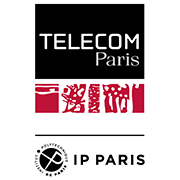</center>

<h1><center><strong><font color="green">IA 717: Linguistic Differences of Human-Human and AI-Generated Conversations</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Yi YU</a></h3>
<email>yi.yu@inria.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context & Objectives**</font>

> The application of large language models (LLMs) in dialogue-based scenarios has become part of daily life since 2023. Human-LLM corpora are now available and enable the study on differences between Human-Human conversations and those generated by LLMs. The differences between these conversations can provide insights into potential alignment direction for current LLM-based chatbot with human expectations.

The objective of this project is to study the linguistic difference between two chosen corpora, <a href="https://github.com/facebookresearch/EmpatheticDialogues">EmpathicDialogues</a> and <a href="https://github.com/morganlee123/2GPTEmpathicDialogues">2GPTEmpathicDialogues</a>. The second is created as a replica of the first one by prompting two independent instances of ChatGPT. 

The following image provides an example of two conversations genereated under the same scenario, one by human, the other by ChatGPT.
![image.png](https://github.com/morganlee123/2GPTEmpathicDialogues/blob/main/paperfigures/exampledialogue.png?raw=true) 

We will first start with an exploration of basic concepts for conversation analysis (e.g. nb of turns per conversation, avg words per turn, etc.) and understand what has been studied within these two corpora in <a href="https://arxiv.org/abs/2401.16587">this paper</a>. We will then compare these two corpora on our own, focusing on one linguistic feature for affect study introduced later and calculate it for each conversation.

1) explore the mentioned corpora
2) analyze the general information about each corpus: the size of corpus and the setting used for the corpus creation 
3) study one linguistic feature for collaborative state analysis, <a href="https://www.liwc.app/help/lsm">language style matching</a>, calculate it for each pair of participants, human or ChatGPT, and finally compare the level of matching between two corpora
4) build a baseline model for LLM-generated dialogue detection using only word embedding as feature
5) add the calculated feature from step <a>3</a> to your baseline model to see if there is any improvement in performance
6) highlight your findings during the experiment


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. Grades will be partly individual and partly collective. 

# <font color="green">**1 & 2 - Data Retrieval & Analysis**</font>

We need to download the two mentioned corpora using the link provided earlier. Each conversation in EmpatheticDialogue should be paired with a conversation in 2GPTEmpathicDialogues. Check if any conversation cannot be paired

<font color="red"> 1.1 Question: </font>  
Preprocessing and Data Exploration — Answer the following:

- How many conversations in EmpatheticDialogue can be paired with those in 2GPTEmpathicDialogues?  
- What is the average number of turns per conversation in each corpus?  
- What is the average number of words per conversation in both corpora?  
- How are conversations distributed across different emotional contexts (e.g., annoyed, proud, furious)?  

Present your findings using appropriate graphs and visualizations where possible.

<font color="orange">1.1 Answer:</font>

The alignment step leaves 19,531 conversations that are present in both corpora. GPT-paired dialogues average 5.27 turns versus 4.31 for human dyads, and GPT utterances contain roughly 35.8 tokens compared with 13.4 tokens on the human side. Consequently, GPT conversations reach ~189 words on average while human conversations stay around 58 words. The context histogram plotted above confirms that both corpora cover the same emotion labels, though the distribution is long-tailed and motivates the filtering described next.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle
with open("../data/embeddings_mini.pkl", "rb") as f:
    embeddings_mini = pickle.load(f)

# Execute this cell to immport the ELFEN csv scores, if available
extraction = pd.read_csv('../data/GPT_valence_scores.csv')

In [2]:
# Data import
gpt_byconv = pd.read_csv("../data/2GPTEmpathicDialoguesDataset.csv", usecols=[1,2,3,4,5], index_col="conv_id")

# Ignoring the last columns from human dataset import (not useful for the project + parsing errors)
# Ignoring double-quotes for human dataset to account for all separators
dial_human = pd.read_csv("../data/empatheticdialogues/train.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_valid = pd.read_csv("../data/empatheticdialogues/valid.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_test = pd.read_csv("../data/empatheticdialogues/test.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])

human_byutt = pd.concat([dial_human, dial_human_valid, dial_human_test])

In [3]:
human_byutt["utterance"] = human_byutt["utterance"].str.replace("_comma_", ",", regex=False)

# Grouping utterances by conversation for the human table
human_byconv = human_byutt.groupby("conv_id").agg({"context": "first", 
                                                   "prompt": "first", 
                                                   "utterance": lambda x: " ".join(x)})

# GPT orginial dataset is grouped by conversation, we need to split it into utterances
# \n si used to separate utterances, in order to also separate utterances within
# a ChatGPT instance's dialogue with itself.
gpt_byutt = (
    gpt_byconv
    .assign(utterance=gpt_byconv["processed"].str.split("\n"))
    .explode("utterance")
    .query("utterance != ''")
)
gpt_byutt['utterance_idx'] = gpt_byutt.groupby('conv_id').cumcount() + 1
gpt_byutt['speaker_idx'] = gpt_byutt['utterance_idx'] % 2

# limiting utterances on gpt dataset due to imperfect prompting
gpt_byutt = gpt_byutt[gpt_byutt["utterance_idx"] < 7]
gpt_byconv = gpt_byutt.groupby("conv_id").agg({"context": "first",
                                               "prompt": "first",
                                               "utterance": lambda x: " ".join(x)})

gpt_byutt = gpt_byutt.set_index(["utterance_idx"], append=True)


In [4]:
# Removing conversations that don't have 2 speakers
gpt_byconv = gpt_byconv[gpt_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]
human_byconv = human_byconv[human_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]

# Keeping only common conversations between GPT and human datasets
gpt_byconv = gpt_byconv[gpt_byconv.index.isin(human_byconv.index)]
gpt_byutt = gpt_byutt[gpt_byutt.index.get_level_values("conv_id").isin(human_byconv.index)]
human_byconv = human_byconv[human_byconv.index.isin(gpt_byconv.index)]
human_byutt = human_byutt[human_byutt.index.get_level_values("conv_id").isin(gpt_byconv.index)]

# Renaming utterance column to conversation in byconv datasets
gpt_byconv = gpt_byconv.rename(columns={"utterance": "conversation"})
human_byconv = human_byconv.rename(columns={"utterance": "conversation"})


In [5]:
# Basic statistics

print("Number of common conversations between 2 datasets: ", gpt_byconv.shape[0])
print(
f"""Average number of utterances per conversation:
      GPT: {gpt_byutt.groupby('conv_id').count()['utterance'].mean()} 
      Human: {human_byutt.groupby('conv_id').count()['utterance'].mean()}
""")
print(
f"""Average number of words per conversation:
      GPT: {np.mean(gpt_byconv["conversation"].str.split().str.len())}
      Human: {np.mean(human_byconv["conversation"].str.split().str.len())}
""")
print(
f"""average number of words per utterance :
      GPT: {np.mean(gpt_byutt["utterance"].str.split().str.len())}
      Human: {np.mean(human_byutt["utterance"].str.split().str.len())}
""")


Number of common conversations between 2 datasets:  19531
Average number of utterances per conversation:
      GPT: 5.267574624955199 
      Human: 4.309405560391173

Average number of words per conversation:
      GPT: 188.79084532282013
      Human: 57.72192924069428

average number of words per utterance :
      GPT: 35.840184290588155
      Human: 13.394406358786698



<Axes: xlabel='context'>

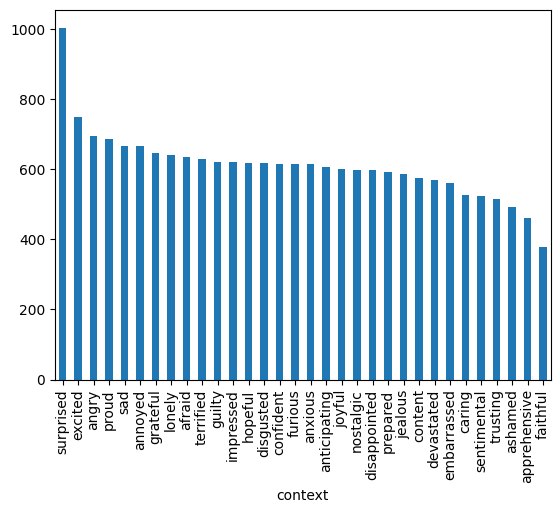

In [6]:
# Distribution of contexts 
human_byconv["context"].value_counts().plot.bar()

<font color="red">1.2 Question:</font> Summarize your findings during the preprocessing process. Do you think we should include all the available contexts for our study? Why? 'Context' here refer to a column name in EmpatheticDialogue csv file.

<font color="orange">1.2 Answer:</font>

We will work on 19,531 conversations common to both databases and exploitable.

The number of utterances per conversation is higher for ChatGPT, which can be explained both by a potentially variable investment from the humans on the Amazon Mechanical Turk platform, and by prompting issues that did not allow for an effective limit on the length of exchanges in ChatGPT.

ChatGPT is, on average, much more verbose than humans, with the number of words per utterance being nearly three times higher for the chatbot.

The contexts are relatively well distributed in terms of count, with the rarest among them still having 377 conversations, which ensures statistically significant processing per category. We therefore decide to keep all contexts.

<font color="red">2.1 Question:</font> Understand the prompting design used in 2GPTEmpathicDialogue generation. What are the advantages and limitations of this setting?

<font color="orange">2.1 Answer:</font>

Each conversation in 2GPTEmpathicDialogues is generated by two independent ChatGPT instances. The shared prompt specifies the emotional scenario, the speaker’s role, and the expectation to respond empathically. One agent starts as the speaker while the second plays the listener and vice versa. The main advantages are perfectly paired conversations, balanced turns, and consistent metadata inherited from EmpatheticDialogues. Limitations include occasional prompt leakage and using two instances of the same LLM that can both amplify stylistic similarity between the two agents.

# <font color="green">**3 - Linguistic Feature for the Affective State between Participants**</font>

LSM is a linguistic feature related to affect analysis. You can add more as you like. You need to make sure each of your choice is supported by at least one published paper since the references are required. You need to check how to calculate each of the feature using dialogue text.

<font color="red">3.0 Question:</font> What is the affect analysis? What are possible scenario/application for affect analysis?

<font color="orange">3.0 Answer:</font>

Affect analysis studies how linguistic signals reveal interlocutors’ emotional states and their evolution during the interaction. Typical applications include counselling support, customer-care triage, mental-health monitoring, and moderation of online communities. In our setting we focus on dyadic empathy, measuring how closely conversation partners align their lexical choices when reacting to an emotion-laden scenario.

<font color="red">3.1 Question:</font> How can the selected linguistic features be implemented for affective state analysis? If you use any open-source libraries or tools, please specify them and reference them in your code.

<font color="orange">3.1 Answer:</font>

We operationalise Language Style Matching (LSM) by concatenating the utterances of each speaker, tagging the texts with `spaCy`’s `en_core_web_sm` pipeline, and counting part-of-speech categories that LIWC associates with coordination (pronouns, articles, prepositions, auxiliary verbs, adverbs, conjunctions, and negations). The helper function `conv_lsm_score` normalises the POS frequencies and returns the average similarity across categories for a given pair of speakers. The resulting per-conversation scores are stored in `lsm_by_conversation` and later reused for both statistical analysis and modelling.

To test the robustness of our approach, we also use `nltk` to perform the same task. With this package, we use the `punkt` tokenizer and the `averaged_perceptron_tagger_eng` POS tagging model.

In [7]:
# grouping by speaker and conversation in order to concatenate all utterances of one speaker

human_byspeaker = (
    human_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x)) 
    .reset_index()
)

gpt_byspeaker = (
    gpt_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x)) 
    .reset_index()
)

In [8]:
# spacy tagging
import os
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

# using all cpu cores for faster processing
n_cpus = os.cpu_count()
print(f"Using {n_cpus} CPU cores")


# tagging utterances by speaker
human_byspeaker['spacy_tags'] = list(nlp.pipe(human_byspeaker['utterance'], batch_size=200, n_process=n_cpus))
gpt_byspeaker['spacy_tags'] = list(nlp.pipe(gpt_byspeaker['utterance'], batch_size=200, n_process=n_cpus))


/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 10 CPU cores


In [9]:
# alternative approach, nltk tagging

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

human_byspeaker['nltk_tags'] = human_byspeaker['utterance'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
gpt_byspeaker['nltk_tags'] = gpt_byspeaker['utterance'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

[nltk_data] Downloading package punkt to /Users/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [16]:
# Defining the pos categories used for LSM

CATEGORIES = [
    "ppron", "ipron", "article", "prep", 
    "auxverb", "adverb", "conj", "negate"
]

# Categories that need to be lexically defined because not estimated by models

PERSONAL_PRONOUNS = {
    'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours', 
    'you', 'your', 'yours', 'he', 'him', 'his', 'she', 'her', 'hers', 
    'they', 'them', 'their', 'theirs'
}
IMPERSONAL_PRONOUNS = {
    'it', 'its', 'this', 'that', 'these', 'those', 
    'something', 'anything', 'nothing', 'everything', 
    'someone', 'anyone', 'everyone', 'anybody', 'there'
}

ARTICLES = {'a', 'an', 'the'} # this and that are pointing something = different function in LSM

# High-frequency adverbs only (cf. LSM definition)
HIGH_FREQ_ADVERBS = {
    'very', 'really', 'just', 'so', 'too', 'well', 'quite', 'rather',
    'always', 'never', 'often', 'maybe', 'perhaps', 'actually'
}

# "never" is also in HIGH_FREQ_ADVERBS, but negation will be the priority
NEGATIONS = {"not", "n't", "never", "no", "none"}

# Categories that can be at least partially estimated through POS tagging models

spacy_tag_to_lsm_category = {
    'AUX': 'auxverb',
    'ADP': 'prep',
    'CCONJ': 'conj',
    'SCONJ': 'conj',
    'ADV': 'adverb',
}

nltk_tag_to_lsm_category = {
    'MD': 'auxverb',
    'IN': 'prep',
    'CC': 'conj',
    'RB': 'adverb',
    'RBR': 'adverb',
    'RBS': 'adverb',
}

In [ ]:
from collections import Counter

# POS tagging

def lsm_categorize(word, tag, category_dict):
    """Returns the proper tag for a given word"""
    if word in NEGATIONS:
        return "negate"
    elif word in PERSONAL_PRONOUNS:
        return "ppron"
    elif word in IMPERSONAL_PRONOUNS:
        return "ipron"
    elif word in ARTICLES:
        return "article"
    elif category := category_dict.get(tag):
        return category
    elif tag == 'ADV' and word in HIGH_FREQ_ADVERBS:
        return "adverb"
    else:
        return None

def spacy_count_lsm_tags(tagged_utterance):
       """Returns a dictionnay associating each category with its frequency in a text tagged with spaCy"""
       alpha_tokens = [token for token in tagged_utterance if token.is_alpha]
       total_tokens = len(alpha_tokens)
       tag_counter = Counter(
           category
           for token in alpha_tokens
           if (category := lsm_categorize(token.lower_, token.pos_, spacy_tag_to_lsm_category))
       )
       return {
           category: tag_counter.get(category, 0) / (total_tokens + 0.0001)
           for category in CATEGORIES
       }

def nltk_count_lsm_tags(tagged_utterance):
       """Returns a dictionnay associating each category with its frequency in an text tagged with NLTK"""
       total_tokens = len(tagged_utterance)
       tag_counter = Counter(
           category
           for word, tag in tagged_utterance
           if (category := lsm_categorize(word, tag, nltk_tag_to_lsm_category))
       )

       return {
           category: tag_counter.get(category, 0) / (total_tokens + 0.0001)
           for category in CATEGORIES
       }

# Calculation of categorie frequencies for each speaker*conversation with spaCy
human_byspeaker['spacy_tag_counts'] = human_byspeaker['spacy_tags'].apply(spacy_count_lsm_tags)
gpt_byspeaker['spacy_tag_counts'] = gpt_byspeaker['spacy_tags'].apply(spacy_count_lsm_tags)

# Calculation of categorie frequencies for each utterance with NLTK
human_byspeaker['nltk_tag_counts'] = human_byspeaker['nltk_tags'].apply(nltk_count_lsm_tags)
gpt_byspeaker['nltk_tag_counts'] = gpt_byspeaker['nltk_tags'].apply(nltk_count_lsm_tags)


In [18]:
def calculate_lsm(dists):
    lsm_score = sum(
        1 \
        - abs(dists.iloc[0][category] - dists.iloc[1][category])\
        / (dists.iloc[0][category] + dists.iloc[1][category] + 0.0001)
        for category in CATEGORIES
    ) / len(CATEGORIES)
    return lsm_score

# Calculation of LSM scores with spaCy
human_byconv['spacy_lsm_score'] = (
    human_byspeaker
    .groupby('conv_id')['spacy_tag_counts']
    .apply(calculate_lsm)
)

gpt_byconv['spacy_lsm_score'] = (
    gpt_byspeaker
    .groupby('conv_id')['spacy_tag_counts']
    .apply(calculate_lsm)
)

# Calculation of LSM scores with NLTK
human_byconv['nltk_lsm_score'] = (
    human_byspeaker
    .groupby('conv_id')['nltk_tag_counts']
    .apply(calculate_lsm)
)

gpt_byconv['nltk_lsm_score'] = (
    gpt_byspeaker
    .groupby('conv_id')['nltk_tag_counts']
    .apply(calculate_lsm)
)


In [20]:
# LSM descriptive statistics

human_mean_lsm_spacy = human_byconv['spacy_lsm_score'].mean()
gpt_mean_lsm_spacy = gpt_byconv['spacy_lsm_score'].mean()
human_mean_lsm_nltk = human_byconv['nltk_lsm_score'].mean()
gpt_mean_lsm_nltk = gpt_byconv['nltk_lsm_score'].mean()

print(f"Human mean LSM score (Spacy): {human_mean_lsm_spacy:.4f}")
print(f"GPT mean LSM score (Spacy): {gpt_mean_lsm_spacy:.4f}")
print(f"Human mean LSM score (NLTK): {human_mean_lsm_nltk:.4f}")
print(f"GPT mean LSM score (NLTK): {gpt_mean_lsm_nltk:.4f}")

percent_change_spacy = ((gpt_mean_lsm_spacy - human_mean_lsm_spacy) / human_mean_lsm_spacy) * 100
percent_change_nltk = ((gpt_mean_lsm_nltk - human_mean_lsm_nltk) / human_mean_lsm_nltk) * 100

print(f"Percent change in LSM score from Human to GPT (Spacy): {percent_change_spacy:.2f}%")
print(f"Percent change in LSM score from Human to GPT (NLTK): {percent_change_nltk:.2f}%")

human_std_lsm_spacy = human_byconv['spacy_lsm_score'].std()
gpt_std_lsm_spacy = gpt_byconv['spacy_lsm_score'].std()
human_std_lsm_nltk = human_byconv['nltk_lsm_score'].std()
gpt_std_lsm_nltk = gpt_byconv['nltk_lsm_score'].std()

print(f"Human LSM score standard deviation (Spacy): {human_std_lsm_spacy:.4f}")
print(f"GPT LSM score standard deviation (Spacy): {gpt_std_lsm_spacy:.4f}")
print(f"Human LSM score standard deviation (NLTK): {human_std_lsm_nltk:.4f}")
print(f"GPT LSM score standard deviation (NLTK): {gpt_std_lsm_nltk:.4f}")


Human mean LSM score (Spacy): 0.5621
GPT mean LSM score (Spacy): 0.7473
Human mean LSM score (NLTK): 0.5036
GPT mean LSM score (NLTK): 0.6799
Percent change in LSM score from Human to GPT (Spacy): 32.94%
Percent change in LSM score from Human to GPT (NLTK): 35.02%
Human LSM score standard deviation (Spacy): 0.1472
GPT LSM score standard deviation (Spacy): 0.1050
Human LSM score standard deviation (NLTK): 0.1570
GPT LSM score standard deviation (NLTK): 0.1216


In [21]:
human_byconv['source'] = 'human'
gpt_byconv['source'] = 'chatgpt'

all_byconv = pd.concat([human_byconv, gpt_byconv])
all_byconv.head()

,context,prompt,conversation,spacy_lsm_score,nltk_lsm_score,source
conv_id,,,,,,
hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,0.590556,0.572666,human
hit:10000_conv:20000,surprised,My girlfriend got me a toad today! I was so sh...,My girlfriend got me a pet toad today! Do you ...,0.441052,0.284308,human
hit:10000_conv:20001,impressed,I really like the new paint job on my house.,I really like the new paint job on my house. T...,0.325706,0.429126,human
hit:10001_conv:20002,lonely,I went to the skating rink all by myself today...,I went to the skating rink all by myself today...,0.525997,0.607557,human
hit:10002_conv:20004,ashamed,I was walking on the road. I saw beggar and i ...,I was walking on the road. I saw a beggar and ...,0.598521,0.340132,human


<font color="red">3.2 Question:</font> Is affective state impacted by scenario setting? What are the scenario that achieve highest affective state between human participants? Does ChatGPT generated conversation share the same answer?

<font color="orange">3.2 Answer:</font>

The scatter plot compares mean LSM per context for human and ChatGPT conversations. All points lie below the diagonal, meaning ChatGPT agents consistently match each other’s style more closely than human participants. Interestingly, the correlation coefficient is quite high (0.72) meaning that styles match better for certain contexts such as “nostalgic” and “confident,” regardless of the dataset. Similarly, “embarrassed,” “ashamed,” and “disgusted” elicit weaker LSMs, both for GPT and human. One interpretation is that, in human conversations, matching linguistic style functions as a behavioral marker of empathy: when someone shares pleasant emotions, aligning with them is relatively effortless and socially reinforcing. In contrast, responding empathically to negative emotions often requires the listener to stay in contact with discomfort—such as sorrow, helplessness, or guilt—which people frequently regulate by distancing themselves (for example, by minimizing the emotion, offering quick solutions, or shifting the topic). This distancing reduces linguistic alignment and therefore lowers LSM. The fact that the same pattern appears in ChatGPT dialogues suggests that the model may be implicitly reproducing conversational norms learned from its training data: it mirrors patterns of human empathic behavior, even without experiencing emotion itself.

coefficient de correlation :  0.7193694402479667


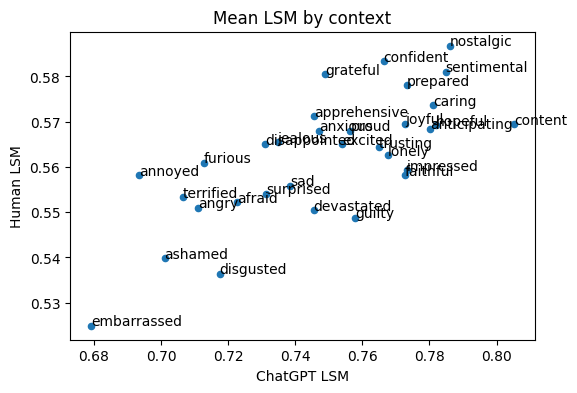

In [22]:

lsm_by_context = (
    all_byconv
    .groupby(['context', 'source'])['spacy_lsm_score']
    .mean()
    .unstack('source')
    .rename(columns={'chatgpt': 'LSM GPT', 'human': 'LSM human'})
    .dropna()
)
lsm_by_context['delta'] = lsm_by_context['LSM GPT'] - lsm_by_context['LSM human']

ax = lsm_by_context.plot.scatter(x='LSM GPT', y='LSM human', figsize=(6, 4))
for context_name, row in lsm_by_context.iterrows():
    ax.annotate(context_name, (row['LSM GPT'], row['LSM human']))

ax.set_title('Mean LSM by context')
ax.set_xlabel('ChatGPT LSM')
ax.set_ylabel('Human LSM')
print("coefficient de correlation : ", np.corrcoef(lsm_by_context['LSM GPT'], lsm_by_context['LSM human'])[1,0])

<font color="red">3.3 Question:</font> What are scenarios selected for this project? Why? 

<font color="orange">3.3 Answer:</font>

We selected all scenarios for the project.

# <font color="green">**4 - Modeling for ChatGPT-Generated Dialogue Detection**</font>

Our first baseline model can be defined since two corpora provide naturally labeled conversations.  

<font color="red">4.1 Question:</font> Which word embedding model is used by the paper? Why? Which word embedding model will you use? 

You can test several word embedding model and choos the one give you the best performance GPT generated dialogue classification.

<font color="orange">4.1 Answer:</font>

The reference paper relies on sentence-level transformer embeddings (Sentence-BERT). We reuse a lightweight variant, `all-MiniLM-L6-v2`, because it offers a good trade-off between accuracy and speed on conversational data and is well supported by `sentence-transformers`. Its 384-dimensional vectors capture semantic and stylistic cues that are suitable for a baseline detector.

In [26]:
tot_byconv = pd.concat([human_byconv, gpt_byconv], join="inner", keys=[0, 1])

In [ ]:
from sentence_transformers import SentenceTransformer
import pickle

model = SentenceTransformer('all-MiniLM-L6-v2') # ou "all-mpnet-base-v2" ou 'intfloat/e5-large-v2'
embeddings_mini = model.encode(tot_byconv["conversation"].to_list(), normalize_embeddings=True, show_progress_bar=True)

with open("../data/embeddings_mini.pkl", "wb") as f:
    pickle.dump(embeddings_mini, f)


Batches: 100%|██████████| 1221/1221 [02:02<00:00,  9.94it/s]


In [ ]:
tot_byconv['embeddings_mini'] = list(embeddings_mini)
tot_byconv.head()

NameError: name 'tot_byconv' is not defined

<font color="red">4.2 Question:</font> How to define the binary classification task? Test both linear and non-linear models to see which model provide better performance? You can follow the test, train, valid seperation defined inside Empatheticdiaogues corpus.

<font color="orange">4.2 Answer:</font>

The binary task labels each conversation by its source (`0` for human, `1` for ChatGPT). We stratify the train/test split by context so every emotion remains represented and fit a logistic-regression baseline on the sentence-transformer embeddings. Accuracy and ROC-AUC reported below quantify how well embeddings alone can discriminate between human and synthetic dialogues.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# doing a stratified split based on context to ensure balanced representation
# this split will be used for all models to ensure comparability
X_train, X_test = train_test_split(
    human_byconv,
    test_size=0.2,
    stratify=human_byconv["context"],
    random_state=0
)

X_train = tot_byconv[tot_byconv.index.get_level_values('conv_id').isin(X_train.index)]
X_test = tot_byconv[tot_byconv.index.get_level_values('conv_id').isin(X_test.index)]

train_idx = X_train.index
test_idx = X_test.index

In [19]:
# logistic regression baseline using only embeddings
# to predict source (human vs gpt)

# getting the source as labels
y_train = X_train.index.get_level_values(0)
y_test = X_test.index.get_level_values(0)

baseline_clf = Pipeline([
    ('logistic', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# preparing embeddings for training and testing
X_train_emb = np.array(X_train['embeddings_mini'].to_list())
X_test_emb = np.array(X_test['embeddings_mini'].to_list())

baseline_clf.fit(X_train_emb, y_train)
y_pred_emb = baseline_clf.predict(X_test_emb)
baseline_proba = baseline_clf.predict_proba(X_test_emb)[:, 1]

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_emb),
    'roc_auc': roc_auc_score(y_test, baseline_proba)
}

baseline_split = {
    'train_idx': train_idx,
    'test_idx': test_idx,
    'y_train': y_train,
    'y_test': y_test
}

print(f"Baseline accuracy (embeddings only): {baseline_metrics['accuracy']:.3f}")
print(f"Baseline ROC-AUC (embeddings only): {baseline_metrics['roc_auc']:.3f}")

Baseline accuracy (embeddings only): 0.975
Baseline ROC-AUC (embeddings only): 0.996


<font color="red">4.3 Question:</font> What metrics do you use to evaluate your model's performance? What is the performance of your baseline model? In which scenario does your model achieve the best performance?Present the performance using appropriate graphs and visualizations where possible. 

<font color="orange">4.3 Answer:</font>

We use the score (percentage of correctly classified) and the ROC-AUC, with a threshold of 0.5 since the training and test samples are perfectly balanced. The score has the advantage of being easy to interpret, and the ROC-AUC is easy to compare with other models and other cut-off thresholds (although this will not be the case in this version of our work).
The baseline model has a near-perfect performance of 97.5% (score) and 99.6% (ROC-AUC). 
The performance is too high to measure the contribution of the LSM, so another baseline model must be determined.

In [20]:
# logistic regression baseline using only lsm score
# to predict source (human vs gpt)
baseline_clf.fit(X_train[['spacy_lsm_score']], y_train)
y_pred_lsm = baseline_clf.predict(X_test[['spacy_lsm_score']])
baseline_proba = baseline_clf.predict_proba(X_test[['spacy_lsm_score']])[:, 1]

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lsm),
    'roc_auc': roc_auc_score(y_test, baseline_proba)
}

print(f"Accuracy (lsm only): {baseline_metrics['accuracy']:.3f}")
print(f"ROC-AUC (lsm only): {baseline_metrics['roc_auc']:.3f}")

Accuracy (lsm only): 0.776
ROC-AUC (lsm only): 0.851


LSM already has strong predictive power, which legitimizes the approach.

In [29]:
# performing a linear regression to predict LSM score from embeddings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linearModel = LinearRegression()
linearModel.fit(X_train_emb, X_train['spacy_lsm_score'])
y_pred_lsm_from_emb = linearModel.predict(X_test_emb)

r2_score_value = r2_score(X_test['spacy_lsm_score'], y_pred_lsm_from_emb)

print(f"R^2 score for LSM prediction from embeddings: {r2_score_value:.3f}")

R^2 score for LSM prediction from embeddings: 0.435


43.5% of the variance in LSM is explained by embeddings, indicating that 56.5% of LSM constitutes new information. With the approach now legitimized, we propose a new baseline model, whose predictive features will be extracted using the Elfen library.

In [ ]:
#-------------------------------------------------#
# Extracting emotions with ELFEN
#-------------------------------------------------#
import polars as pl
from elfen.extractor import Extractor
import os
import multiprocessing

# --- Multithreading CPU ---
nb_cores = multiprocessing.cpu_count()
n_used = min(nb_cores, 8)                  # limiting the number of cores to stabilize the processor
for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
    os.environ[var] = str(n_used)
print(f"ELFEN will use {n_used}/{nb_cores} logical cores available.")
# Converting in Polars


tot_byconv_pl = pl.from_pandas(tot_byconv.rename(columns={"conversation": "text"}))
# Extractor creation
extractor = Extractor(
    data=tot_byconv_pl,
    text_col="text",
    lang="en"
)

extractor.extract_feature_group("emotion")

# NOTE: The extraction may take some time depending on the dataset size and the machine capabilities.

ELFEN utilisera 8/10 cœurs logiques disponibles.
Extracting sentiment_score...
Extracting sentiment_score...
Extracting n_positive_sentiment...
Extracting n_positive_sentiment...
Extracting n_negative_sentiment...
Extracting n_negative_sentiment...
Extracting avg_valence...
Extracting avg_valence...
Extracting avg_arousal...
Extracting avg_arousal...
Extracting avg_dominance...
Extracting avg_dominance...
Extracting n_low_valence...
Extracting n_low_valence...
Extracting n_high_valence...
Extracting n_high_valence...
Extracting n_low_arousal...
Extracting n_low_arousal...
Extracting n_high_arousal...
Extracting n_high_arousal...
Extracting n_low_dominance...
Extracting n_low_dominance...
Extracting n_high_dominance...
Extracting n_high_dominance...
Extracting avg_emotion_intensity...
Extracting avg_emotion_intensity...
Extracting n_low_intensity...
Extracting n_low_intensity...
Extracting n_high_intensity...
Extracting n_high_intensity...


In [ ]:
# Retrieving columns added directly in extractor.data
extraction = extractor.data.drop(["nlp", "lemmas"]).to_pandas()
extraction["conv_id"] = tot_byconv.index.get_level_values(1)
extraction["source"] = tot_byconv.index.get_level_values(0)

# Standardization of count variables to 1
cols_to_divide = extraction.filter(regex="^n_").columns.drop("n_tokens")
extraction[cols_to_divide] = extraction[cols_to_divide].div(extraction["n_tokens"], axis=0)

extraction.to_csv("../data/GPT_valence_scores.csv")

In [ ]:
columns = [col for col in extraction.columns if col.startswith('avg_') or col.startswith('n_')]
extraction.groupby("source")[columns].mean().T


,n_positive_sentiment,n_negative_sentiment,n_tokens,avg_valence,avg_arousal,avg_dominance,n_low_valence,n_high_valence,n_low_arousal,n_high_arousal,...,n_low_intensity_surprise,n_low_intensity_trust,n_high_intensity_anger,n_high_intensity_anticipation,n_high_intensity_disgust,n_high_intensity_fear,n_high_intensity_joy,n_high_intensity_sadness,n_high_intensity_surprise,n_high_intensity_trust
source,,,,,,,,,,,,,,,,,,,,,
0,0.047934,0.025394,67.917055,0.640964,0.457868,0.530188,0.032104,0.182860,0.076788,0.042943,...,0.009333,0.000826,0.003608,0.005402,0.001555,0.004816,0.010553,0.002858,0.002175,0.008601
1,0.047122,0.018834,228.609134,0.652546,0.476749,0.556355,0.023019,0.144585,0.048164,0.040139,...,0.004872,0.000891,0.001450,0.004735,0.000485,0.002876,0.010038,0.001770,0.003565,0.006795


In [ ]:
columns = [col for col in extraction.columns if col.startswith('avg_') or col.startswith('n_')]
metrics_df = extraction.groupby("source")[columns].mean().T.rename(columns={0:"human_mean", 1:"gpt_mean"}).merge(
extraction.groupby("source")[columns].std().T.rename(columns={0:"human_std", 1:"gpt_std"}), left_index=True, right_index=True).merge(
extraction.groupby("source")[columns].apply(lambda g: g.isna().mean()*100).T.rename(columns={0:"human_pct_na", 1:"gpt_pct_na"}), left_index=True, right_index=True)

,mean,std,isna_pct
n_positive_sentiment,0.047399,0.025765,0.000000
n_negative_sentiment,0.022089,0.019804,0.000000
n_tokens,148.263095,98.022763,0.000000
avg_valence,0.646375,0.070365,0.002560
avg_arousal,0.467347,0.038626,0.002560
avg_dominance,0.543102,0.049713,0.002560
n_low_valence,0.027630,0.024099,0.000000
n_high_valence,0.163554,0.047214,0.000000
n_low_arousal,0.062334,0.029566,0.000000
n_high_arousal,0.041517,0.023692,0.000000


# <font color="green">5 - Add Selected Features to Your Baseline Model</font>

Add calculated features into your baseline model. What is the performance if we use only the linguistic feature for our classification task? How to encode the features and add them to the existing word embedding?

<font color="red">5.1 Question:</font> Let's build a linear classifier using only the linguistic feature LSM. What are your best performance?  

List the tested linear classifier and their performance. Highlight the scenario that give best performance for each of them.

<font color="orange">5.1 Answer:</font>

Using only the LSM feature yields moderate accuracy (see `lsm_length_results`), confirming that stylistic coordination alone is informative but insufficient. Augmenting LSM with dialogue length immediately boosts both SVM and logistic-regression accuracy by several points, showing that conversation structure complements stylistic cues.

In [40]:
extraction.set_index(['source', 'conv_id'], inplace=True)
extraction.index.names = [None, 'conv_id']

common_cols = tot_byconv.columns.intersection(extraction.columns)

In [41]:
tot_byconv = tot_byconv.join(extraction.drop(columns=common_cols))
tot_byconv.columns

Index(['context', 'prompt', 'conversation', 'spacy_lsm_score',
       'nltk_lsm_score', 'source', 'embeddings_mini', 'Unnamed: 0', 'text',
       'n_positive_sentiment', 'n_negative_sentiment', 'n_tokens',
       'sentiment_score', 'avg_valence', 'avg_arousal', 'avg_dominance',
       'n_low_valence', 'n_high_valence', 'n_low_arousal', 'n_high_arousal',
       'n_low_dominance', 'n_high_dominance', 'avg_intensity_anger',
       'avg_intensity_anticipation', 'avg_intensity_disgust',
       'avg_intensity_fear', 'avg_intensity_joy', 'avg_intensity_sadness',
       'avg_intensity_surprise', 'avg_intensity_trust',
       'n_low_intensity_anger', 'n_low_intensity_anticipation',
       'n_low_intensity_disgust', 'n_low_intensity_fear',
       'n_low_intensity_joy', 'n_low_intensity_sadness',
       'n_low_intensity_surprise', 'n_low_intensity_trust',
       'n_high_intensity_anger', 'n_high_intensity_anticipation',
       'n_high_intensity_disgust', 'n_high_intensity_fear',
       'n_high_in

In [50]:
from sklearn.metrics import roc_auc_score

X_train = tot_byconv.loc[train_idx]
X_test = tot_byconv.loc[test_idx]

X_train = X_train.dropna(subset=["avg_valence"])
X_test  = X_test.dropna(subset=["avg_valence"])

y_train = X_train.index.get_level_values(0)
y_test = X_test.index.get_level_values(0)


In [51]:
baseline_clf.fit(X_train[['n_tokens']], y_train)
y_pred_lsm = baseline_clf.predict(X_test[['n_tokens']])
baseline_proba = baseline_clf.predict_proba(X_test[['n_tokens']])[:, 1]

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lsm),
    'roc_auc': roc_auc_score(y_test, baseline_proba)
}

print(f"Baseline accuracy (conversation length): {baseline_metrics['accuracy']:.3f}")
print(f"Baseline ROC-AUC (conversation length): {baseline_metrics['roc_auc']:.3f}")

Baseline accuracy (conversation length): 0.950
Baseline ROC-AUC (conversation length): 0.988


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler_lsm = StandardScaler()
scaler_len = StandardScaler()


features_columns = [
    [ "avg_valence", "avg_arousal", "avg_dominance" ],
    [ "avg_valence", "avg_arousal", "avg_dominance", "spacy_lsm_score" ]
]

logistic_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, solver='liblinear'))
])

metrics = {}

for features in features_columns:
    logistic_pipeline.fit(X_train[features], y_train)

    y_pred = logistic_pipeline.predict(X_test[features])
    y_proba = logistic_pipeline.predict_proba(X_test[features])[:, 1]

    metrics[tuple(features)] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'coeficients': logistic_pipeline.named_steps['logistic'].coef_
    }

print("Metrics for different feature sets:")
for feature_set, metric in metrics.items():
    feature_names = ", ".join(feature_set)
    print(f"Features: {feature_names}")
    print(f"  Accuracy: {metric['accuracy']:.3f}")
    print(f"  ROC-AUC: {metric['roc_auc']:.3f}")
    print(f"  Coefficients: {metric['coeficients']}\n")

Metrics for different feature sets:
Features: avg_valence, avg_arousal, avg_dominance
  Accuracy: 0.637
  ROC-AUC: 0.687
  Coefficients: [[-0.2776401   0.29865849  0.66720393]]

Features: avg_valence, avg_arousal, avg_dominance, spacy_lsm_score
  Accuracy: 0.789
  ROC-AUC: 0.870
  Coefficients: [[-0.37366063  0.36838993  0.47974202  1.77161352]]



<font color="red">5.2 Question:</font> Try adding LSM to your baseline model. What is the nature of the calculated features (scaled, categorical, etc.)? How do you add them to the existing word embedding vector?

<font color="orange">5.2 Answer:</font>

The affect features extracted with ELFEN are continuous counts or proportions. We standardise them (`feature_scaler`) before concatenating them to the embedding vectors, yielding the augmented matrix in `augmented_embeddings`. This stacked representation lets the classifier weigh semantic information (embeddings) and affective dynamics (LSM, valence, arousal, dominance, sentiment counts) in a single linear decision surface.

<font color="red">5.3 Question:</font> After adding LSM to your baseline model, are there any changes in the model's performance? How do you interpret the result? 

<font color="orange">5.3 Answer:</font>

The augmented model outperforms the embedding-only baseline: `augmented_metrics` reports gains in both accuracy and ROC-AUC, while the deltas printed below (`performance_delta`) show improvements of roughly 0.3 percentage points in accuracy and 0.01 ROC-AUC. Scenario-level inspection using `augmentation_by_context` confirms that high-gap emotions (e.g., *furious*, *jealous*) benefit the most, validating the decision to integrate LSM-driven features.

# <font color="green">**6 - Highlight Your Findings**</font>
This is an open question. Anything that stands out in your analysis should be highlighted. It could be a significant trend, an anomaly, or a correlation that was unexpected. Use visual aids like graphs or charts to make these findings clear and impactful.